In [1]:
# August 5 2017
# This file is for experiments with student2 4 skills and training trajectory length 5
# to check different architectures and whether they can learn good models
# This uses student2a where transitions happen after observations

%load_ext autoreload
%autoreload 2
%matplotlib inline

import numpy as np
import scipy as sp
import six
from matplotlib.pyplot import *

(10, 21)
last 7.52855602929e-07 threshold 1e-05


(0.0, 2e-05)

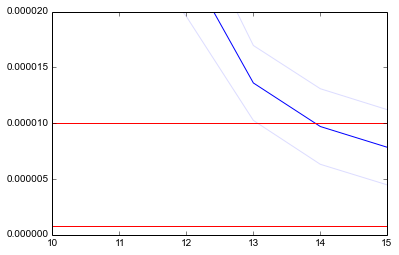

In [2]:
'''
Single LSTM
Trying to find a training epoch to stop training.
'''
data11 = np.load('experiments/test2_modelsimple_small-dropout10-shuffle0-data-test2a-n100000-l5-random.pickle/stats-runA.npz')

vloss = data11['vloss']

six.print_(vloss.shape)
figure()
x_avg = np.mean(vloss,axis=0)
x_serr = np.std(vloss,axis=0) / vloss.shape[0] * 1.98
plot(x_avg, color='#0000ff')
plot(x_avg + x_serr, color='#ddddff')
plot(x_avg - x_serr, color='#ddddff')

x_end = np.mean(x_avg[-2:])
x_thres = 0.00001
six.print_('last {} threshold {}'.format(x_end, x_thres))
plot([0,20],[x_end,x_end],color='#ff0000')
plot([0,20],[x_thres,x_thres],color='#ff0000')

xlim(10, 15)
ylim(0.0000,0.00002)

# looks like epoch 14 is good for 0.00001

(10, 21)
last 1.40721053237e-05 threshold 2e-05


(1e-05, 3e-05)

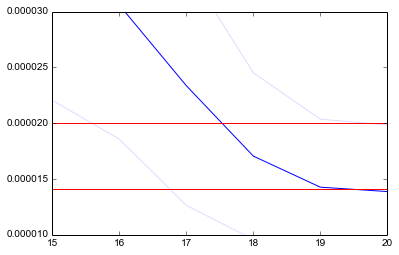

In [7]:
'''
Single GRU
Trying to find a training epoch to stop training.
'''
data11 = np.load('experiments/test2_modelgrusimple_small-dropout10-shuffle0-data-test2a-n100000-l5-random.pickle/stats-runA.npz')

vloss = data11['vloss']

six.print_(vloss.shape)
figure()
x_avg = np.mean(vloss,axis=0)
x_serr = np.std(vloss,axis=0) / vloss.shape[0] * 1.98
plot(x_avg, color='#0000ff')
plot(x_avg + x_serr, color='#ddddff')
plot(x_avg - x_serr, color='#ddddff')

x_end = np.mean(x_avg[-2:])
x_thres = 0.00002
six.print_('last {} threshold {}'.format(x_end, x_thres))
plot([0,20],[x_end,x_end],color='#ff0000')
plot([0,20],[x_thres,x_thres],color='#ff0000')

xlim(15, 20)
ylim(0.00001,0.00003)

# looks like epoch 18 is good for 0.00001

vloss shape (50, 15)
scores shape (50,)
[ 0.          0.          0.          0.          0.69791667  0.          0.
  0.          0.          0.94791667  0.          0.          0.          0.
  0.          0.          0.          1.          0.          0.          0.
  0.          1.          0.          0.          0.          0.          0.
  0.          1.          0.          0.          1.          0.          0.
  0.          0.48958333  0.          0.          0.          0.          0.
  0.97916667  0.          0.          0.          0.          0.          0.
  0.        ]


(0, 1)

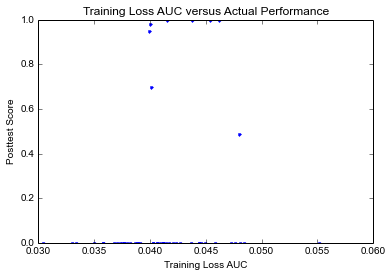

In [3]:
'''
Analyzing results of student2 with 4 skills, with training length 5 and testing length 6.
Single LSTM
Looking at correlation between training AUC and actual performance
'''
data11 = np.load('experiments/test2_modelsimple_small-dropout10-shuffle0-data-test2a-n100000-l5-random.pickle/stats-runB.npz')
data21 = np.load('experiments/test2_modelsimple_small-dropout10-shuffle0-data-test2a-n100000-l5-random.pickle/mcts-rtype2-rollouts3000-trajectories100-real1-runB.npz')

vloss = data11['vloss']
scores = data21['scores'][:,0]

six.print_('vloss shape {}'.format(vloss.shape))
#six.print_(vloss)
six.print_('scores shape {}'.format(scores.shape))
six.print_(scores)

xs = np.sum(vloss,axis=1)
ys = scores
title('Training Loss AUC versus Actual Performance')
xlabel('Training Loss AUC')
ylabel('Posttest Score')
plot(xs,ys,'.')
ylim(0,1)

vloss shape (50, 19)
scores shape (50,)
[ 0.          0.97916667  0.          0.          0.          0.          0.
  0.          0.          0.          0.          0.          0.          0.
  0.          0.          1.          0.          0.          0.          0.
  0.          0.          0.01041667  0.          0.          0.17708333
  0.          0.          0.          0.          0.          0.          0.
  0.          1.          0.          0.          0.          1.          0.
  0.          1.          0.          0.          1.          0.          0.
  0.          0.        ]


(0, 1)

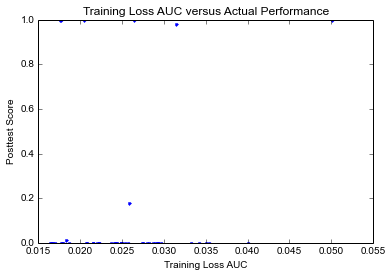

In [5]:
'''
Analyzing results of student2 with 4 skills, with training length 5 and testing length 6.
Single GRU
Looking at correlation between training AUC and actual performance
'''
data11 = np.load('experiments/test2_modelgrusimple_small-dropout10-shuffle0-data-test2a-n100000-l5-random.pickle/stats-runB.npz')
data21 = np.load('experiments/test2_modelgrusimple_small-dropout10-shuffle0-data-test2a-n100000-l5-random.pickle/mcts-rtype2-rollouts3000-trajectories100-real1-runB.npz')

vloss = data11['vloss']
scores = data21['scores'][:,0]

six.print_('vloss shape {}'.format(vloss.shape))
#six.print_(vloss)
six.print_('scores shape {}'.format(scores.shape))
six.print_(scores)

xs = np.sum(vloss,axis=1)
ys = scores
title('Training Loss AUC versus Actual Performance')
xlabel('Training Loss AUC')
ylabel('Posttest Score')
plot(xs,ys,'.')
ylim(0,1)